In [1]:
%pip install vanna[mysql]


  Using cached vanna-0.7.5-py3-none-any.whl.metadata (13 kB)
  Using cached sqlparse-0.5.3-py3-none-any.whl.metadata (3.9 kB)
  Using cached kaleido-0.2.1-py2.py3-none-win_amd64.whl.metadata (15 kB)
  Using cached flask_sock-0.7.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached flasgger-0.9.7.1-py2.py3-none-any.whl
  Using cached PyMySQL-1.1.1-py3-none-any.whl.metadata (4.4 kB)
  Using cached simple_websocket-1.1.0-py3-none-any.whl.metadata (1.5 kB)
Using cached flask_sock-0.7.0-py3-none-any.whl (4.0 kB)
Using cached kaleido-0.2.1-py2.py3-none-win_amd64.whl (65.9 MB)
Using cached PyMySQL-1.1.1-py3-none-any.whl (44 kB)
Using cached sqlparse-0.5.3-py3-none-any.whl (44 kB)
Using cached vanna-0.7.5-py3-none-any.whl (202 kB)
Using cached simple_websocket-1.1.0-py3-none-any.whl (13 kB)
Note: you may need to restart the kernel to use updated packages.


In [93]:
import vanna
from vanna.remote import VannaDefault

In [ ]:
api_key = ""

vanna_model_name = ""
vn = VannaDefault(model=vanna_model_name, api_key=api_key)

In [ ]:
vn.connect_to_mysql(host='localhost', dbname='', user='', password='', port=3306)


EXECUTE ONLY ONCE!!!

In [100]:
ddl_statements="""
CREATE TABLE IF NOT EXISTS orders
                (order_id VARCHAR(50) PRIMARY KEY,
                order_date DATE,
                ship_mode VARCHAR(50), segment VARCHAR(50), city VARCHAR(50),
                state VARCHAR(50), postal_code VARCHAR(50), region VARCHAR(50),
                cost_price INT, list_price INT, quantity INT, discount_percent INT,discount_price DECIMAL (10,2),
                product_id VARCHAR(50),total DECIMAL (10,2), profit DECIMAL (10,2));
CREATE TABLE IF NOT EXISTS products
                (product_id VARCHAR(50) PRIMARY KEY,category VARCHAR(50), sub_category VARCHAR(50));
                """

In [102]:
vn.train(ddl=ddl_statements)


Adding ddl: 
CREATE TABLE IF NOT EXISTS orders
                (order_id VARCHAR(50) PRIMARY KEY,
                order_date DATE,
                ship_mode VARCHAR(50), segment VARCHAR(50), city VARCHAR(50),
                state VARCHAR(50), postal_code VARCHAR(50), region VARCHAR(50),
                cost_price INT, list_price INT, quantity INT, discount_percent INT,discount_price DECIMAL (10,2),
                product_id VARCHAR(50),total DECIMAL (10,2), profit DECIMAL (10,2));
CREATE TABLE IF NOT EXISTS products
                (product_id VARCHAR(50) PRIMARY KEY,category VARCHAR(50), sub_category VARCHAR(50));
                


'429169-ddl'

In [103]:
question_sql_pairs = [
    {
        "question": "Top 10 highest revenue generating products", 
        "sql": """select products.category,products.sub_category,orders.product_id,sum(orders.profit) as revenue
        from orders left join products
        on orders.product_id=products.product_id
        group by orders.product_id,products.category,products.sub_category
        order by revenue desc
        limit 10;"""
    },
    {
        "question": "Top 5 cities with the highest profit margins", 
        "sql": """select city,sum(profit) as profit,sum(total) as total_sales,
        round((sum(profit) / sum(total)) * 100,2) as profit_margin,
        dense_rank() over(order by round((sum(profit) / sum(total)) * 100,2) desc) as position
        from orders
        group by city
        order by position,profit_margin desc
        limit 6;"""
    },
    {
        "question": "Total discount given for each category", 
        "sql": """select products.category,sum(orders.discount_price) as total_discount_offered
        from products inner join orders
        on products.product_id=orders.product_id
        group by products.category
        order by total_discount_offered desc;"""
    },
    {
        "question": "Average sale price per product category", 
        "sql": """select products.category,round(avg(orders.total),2) as average_sale_price
        from products inner join orders
        on products.product_id=orders.product_id
        group by products.category
        order by  average_sale_price desc;"""
    },
    {
        "question": "Region with the highest average sale price", 
        "sql": """select region,round(avg(total),2) as average_sale_price
        from orders
        group by region
        order by average_sale_price desc
        limit 1;"""
    },
    {
        "question": "Total profit per category", 
        "sql": """select products.category,sum(orders.profit) as total_profit
        from products inner join orders
        on products.product_id=orders.product_id
        group by products.category
        order by total_profit desc;"""
    },
    {
        "question": "Top 3 segments with the highest quantity of orders", 
        "sql": """select segment,sum(quantity) as quantity
        from orders
        group by segment
        order by quantity desc;"""
    },
    {
        "question": "Average discount percentage given per region", 
        "sql": """select region,concat(round(avg(discount_percent),2),'%') as avg_discount
        from orders
        group by region;"""
    },
    {
        "question": "Product category with the highest total profit", 
        "sql": """select products.category,sum(orders.profit) as total_profit
        from products inner join orders
        on orders.product_id=products.product_id
        group by products.category
        order by total_profit desc
        limit 1;"""
    },
    {
        "question": "Total revenue generated per year", 
        "sql": """select year(order_date) as year,sum(profit) as revenue
        from orders
        group by year
        order by revenue;"""
    },
    {
        "question": "Total number of orders for each month", 
        "sql": """SELECT YEAR(order_date), MONTH(order_date) AS month, COUNT(order_id) AS total_orders
                  FROM orders
                  GROUP BY YEAR(order_date), MONTH(order_date)
                  ORDER BY YEAR(order_date), MONTH(order_date);"""
    },
    {
        "question": "Top 5 products in terms of revenue within each category", 
        "sql": """SELECT category, product_id, revenue, rnk
                  FROM 
                  (SELECT products.category, products.product_id, SUM(orders.profit) AS revenue,
                          DENSE_RANK() OVER (PARTITION BY products.category ORDER BY SUM(orders.profit) DESC) AS rnk
                   FROM products INNER JOIN orders ON orders.product_id = products.product_id
                   GROUP BY products.category, products.product_id) AS ranked_products
                  WHERE rnk <= 5
                  ORDER BY category, rnk;"""
    },
    {
        "question": "Products whose total profit exceeds the average profit across all products", 
        "sql": """SELECT products.product_id, SUM(orders.profit) AS revenue
                  FROM orders INNER JOIN products
                  ON orders.product_id = products.product_id
                  GROUP BY products.product_id
                  HAVING SUM(orders.profit) > (SELECT AVG(profit) FROM orders)
                  ORDER BY revenue desc;"""
    },
    {
        "question": "Top 3 most profitable subcategories within each product category", 
        "sql": """SELECT category, sub_category, profit, position FROM
                  (SELECT products.category, products.sub_category, SUM(orders.profit) AS profit,
                          DENSE_RANK() OVER (PARTITION BY products.category ORDER BY SUM(orders.profit) DESC) AS position
                   FROM orders INNER JOIN products ON
                        products.product_id = orders.product_id
                   GROUP BY products.category, products.sub_category) AS ranked_sub
                  WHERE position <= 3
                  ORDER BY category, position, profit;"""
    },
    {
        "question": "Top 5 products within each subcategory by total quantity sold", 
        "sql": """SELECT sub_category, product_id, quantity_sold, rnk FROM
                  (SELECT products.sub_category, orders.product_id, SUM(orders.quantity) AS quantity_sold,
                          DENSE_RANK() OVER (PARTITION BY products.sub_category ORDER BY SUM(orders.quantity) DESC) AS rnk
                   FROM orders INNER JOIN products ON
                        orders.product_id = products.product_id
                   GROUP BY products.sub_category, orders.product_id) AS ranked
                  WHERE rnk <= 5
                  ORDER BY sub_category, rnk, quantity_sold;"""
    },
    {
        "question": "Top 3 customer segments with the highest total profit per region", 
        "sql": """SELECT region, segment, profit, rnk FROM
                  (SELECT region, segment, SUM(profit) AS profit,
                          DENSE_RANK() OVER (PARTITION BY region ORDER BY SUM(profit) DESC) AS rnk
                   FROM orders
                   GROUP BY region, segment) AS ranked
                  WHERE rnk <= 3
                  ORDER BY region, rnk, profit;"""
    },
    {
        "question": "Top 3 products with the highest revenue in each customer segment", 
        "sql": """SELECT product_id, segment, profit, rnk FROM
                  (SELECT product_id, segment, SUM(profit) AS profit,
                          DENSE_RANK() OVER (PARTITION BY segment ORDER BY SUM(profit) DESC) AS rnk
                   FROM orders
                   GROUP BY product_id, segment) AS ranked
                  WHERE rnk <= 3
                  ORDER BY segment, rnk, profit;"""
    },
    {
        "question": "For each category, label products by their profit into High(GREATER THAT 10000), MEDIUM(BETWEEN 10000 AND 3000), LOW(BELOW 3000)", 
        "sql": """SELECT products.category, products.product_id, SUM(orders.quantity) AS total_quantity, SUM(orders.profit) AS total_profit,
                  CASE 
                  WHEN SUM(orders.profit) > 10000 THEN 'High Profit' 
                  WHEN SUM(orders.profit) <= 10000 AND SUM(orders.profit) > 3000 THEN 'Medium Profit'  
                  ELSE 'Low Profit' END AS profit_category
                  FROM orders
                  INNER JOIN products ON orders.product_id = products.product_id
                  GROUP BY products.category, products.product_id
                  ORDER BY total_profit DESC;"""
    },
    {
        "question": "Rank the top 5 selling products by region based on total quantity sold using ROW_NUMBER()", 
        "sql": """SELECT region, product_id, total_quantity, rnk FROM
                  (SELECT orders.region, products.product_id, SUM(orders.quantity) AS total_quantity,
                          ROW_NUMBER () OVER (PARTITION BY orders.region ORDER BY SUM(orders.quantity) DESC) AS rnk
                   FROM orders INNER JOIN products ON orders.product_id = products.product_id
                   GROUP BY orders.region, products.product_id) AS ranked
                  WHERE rnk <= 5
                  ORDER BY region, rnk, total_quantity;"""
    },
     {
        "question": "Identify products with a total profit greater than $10,000 but less than 50 units sold for each category", 
        "sql": """SELECT products.category,products.product_id,SUM(orders.quantity) AS total_quantity,
                    SUM(orders.profit) AS total_profit FROM orders
                    INNER JOIN products ON orders.product_id = products.product_id
                    GROUP BY products.category, products.product_id
                    HAVING SUM(orders.profit) > 10000 AND SUM(orders.quantity) < 50
                    ORDER BY total_profit DESC;"""
     },
    {
        "question": "Compare the monthly profit trends between 2023 and 2022.For each month, show whether the profit increased, decreased, or remained the same compared to the previous year",
        "sql": """SELECT MONTH(order_date) AS Month,
                    SUM(CASE WHEN YEAR(order_date)=2022 THEN profit ELSE 0 END) AS Profit_for_Previous_year,
                    SUM(CASE WHEN YEAR(order_date)=2023 THEN profit ELSE 0 END) AS Profit_for_Current_year,
                    CASE
                    WHEN SUM(CASE WHEN YEAR(order_date) = 2023 THEN profit ELSE 0 END) > SUM(CASE WHEN YEAR(order_date) = 2022 THEN profit ELSE 0 END)
                    THEN 'Increased'
                    WHEN SUM(CASE WHEN YEAR(order_date) = 2023 THEN profit ELSE 0 END) < SUM(CASE WHEN YEAR(order_date) = 2022 THEN profit ELSE 0 END) 
                    THEN 'Decreased'
                    ELSE 'No Change'
                    END AS profit_trend
                    FROM orders
                    GROUP BY MONTH(order_date)
                    ORDER BY MONTH(order_date);"""
    }
    
]

# Train Vanna with the multiple question-SQL pairs
for pair in question_sql_pairs:
    vn.train(question=pair["question"], sql=pair["sql"])


In [105]:
training_data = vn.get_training_data()
training_data

,id,training_data_type,question,content
0,718852-sql,sql,Total number of orders for each month,"SELECT YEAR(order_date), MONTH(order_date) AS ..."
1,718845-sql,sql,Average sale price per product category,"select products.category,round(avg(orders.tota..."
2,718842-sql,sql,Top 10 highest revenue generating products,"select products.category,products.sub_category..."
3,718849-sql,sql,Average discount percentage given per region,"select region,concat(round(avg(discount_percen..."
4,718858-sql,sql,Top 3 products with the highest revenue in eac...,"SELECT product_id, segment, profit, rnk FROM\n..."
5,718861-sql,sql,Identify products with a total profit greater ...,"SELECT products.category,products.product_id,S..."
6,718859-sql,sql,"For each category, label products by their pro...","SELECT products.category, products.product_id,..."
7,718851-sql,sql,Total revenue generated per year,"select year(order_date) as year,sum(profit) as..."
8,718843-sql,sql,Top 5 cities with the highest profit margins,"select city,sum(profit) as profit,sum(total) a..."
9,718853-sql,sql,Top 5 products in terms of revenue within each...,"SELECT category, product_id, revenue, rnk\n ..."


SQL Prompt: [{'role': 'system', 'content': "You are a SQL expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \n\nCREATE TABLE IF NOT EXISTS orders\n                (order_id VARCHAR(50) PRIMARY KEY,\n                order_date DATE,\n                ship_mode VARCHAR(50), segment VARCHAR(50), city VARCHAR(50),\n                state VARCHAR(50), postal_code VARCHAR(50), region VARCHAR(50),\n                cost_price INT, list_price INT, quantity INT, discount_percent INT,discount_price DECIMAL (10,2),\n                product_id VARCHAR(50),total DECIMAL (10,2), profit DECIMAL (10,2));\nCREATE TABLE IF NOT EXISTS products\n                (product_id VARCHAR(50) PRIMARY KEY,category VARCHAR(50), sub_category VARCHAR(50));\n                \n\n===Response Guidelines \n1. If the provided context is sufficient, please generate a valid SQL query 

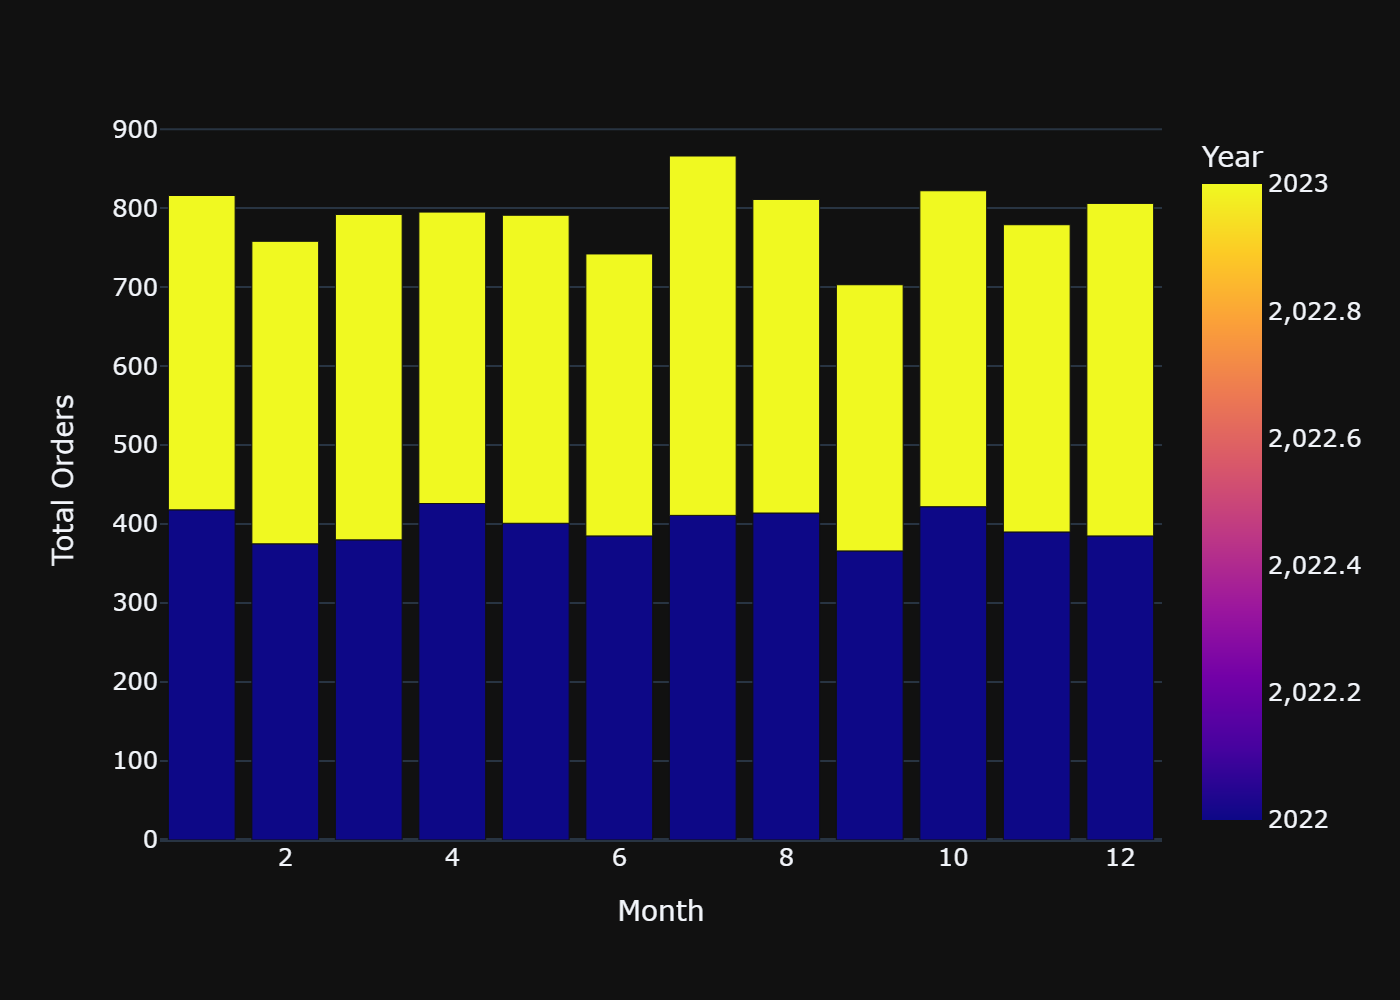

In [108]:
query=vn.ask(question="What is the total number of orders for each month?")

In [60]:
print(query)

('SELECT YEAR(order_date) AS year, MONTH(order_date) AS month, COUNT(order_id) AS total_orders\nFROM orders\nGROUP BY YEAR(order_date), MONTH(order_date)\nORDER BY year, month;',     year  month  total_orders
0   2022      1           418
1   2022      2           375
2   2022      3           380
3   2022      4           426
4   2022      5           401
5   2022      6           385
6   2022      7           411
7   2022      8           414
8   2022      9           366
9   2022     10           422
10  2022     11           390
11  2022     12           385
12  2023      1           398
13  2023      2           383
14  2023      3           412
15  2023      4           369
16  2023      5           390
17  2023      6           357
18  2023      7           455
19  2023      8           397
20  2023      9           337
21  2023     10           400
22  2023     11           389
23  2023     12           421, Figure({
    'data': [{'alignmentgroup': 'True',
              'hovert